# A 3-in-1 Lesson on Manifold-Constrained Hyper Connections, JAX, and Ray
A paper recently published by DeepSeek, [mHC: Manifold-Constrained Hyper-Connections](https://arxiv.org/pdf/2512.24880), introduces a new residual connection paradigm. 

I thought this would be a great opportunity to go over a few concepts at once:
1. **Residual connections**, their importance in deep learning, and what mHC is.
2. **[JAX](https://docs.jax.dev/en/latest/notebooks/thinking_in_jax.html)**, an ML library built by Google that's gaining popularity, and [FLAX NNX](https://flax.readthedocs.io/en/latest/nnx_basics.html), a high-level neural network library for JAX (Gemini 3 was trained using JAX).
3. **[Ray](https://docs.ray.io/en/latest/)**, a distributed computing framework, with libraries for handling data and training models at scale. Ray is used by many, if not most, large ML labs for training large models, like [OpenAI, Google and Anthropic](https://www.run.house/blog/how-to-adopt-ray-without-the-sharp-edges).

### Prerequisites
You probably need some basic understanding of neural networks and Python programming. Familiarity with Pytorch would be helpful since FLAX NNX has a fairly similar API, but not required.

## The Necessity of Residual Connections

In early deep learning (pre-2015), training very deep networks was notoriously difficult due to the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem). As gradients backpropagate through many layers, they multiply, and if the eigenvalues of the weight matrices are small, the gradients shrink exponentially effectively "killing" the learning in earlier layers.

### The Solution: $x_{l+1} = x_l + F(x_l)$

The [Residual Connection](https://openaccess.thecvf.com/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf) allows the gradient to flow directly through the identity path ($x_l$) unimpeded. This acts as a "gradient superhighway."

This simple addition is used in almost every major modern architecture:
*   [ResNet](https://huggingface.co/docs/transformers/v4.32.0/model_doc/resnet) (Vision)
*   [Transformers](https://huggingface.co/docs/transformers/index) (LLMs: [GPT](https://cdn.openai.com/research-covers/language-unsupervised/language_understanding_paper.pdf), [Llama](https://arxiv.org/pdf/2302.13971), [Claude](https://en.wikipedia.org/wiki/Claude_(language_model)), etc.)

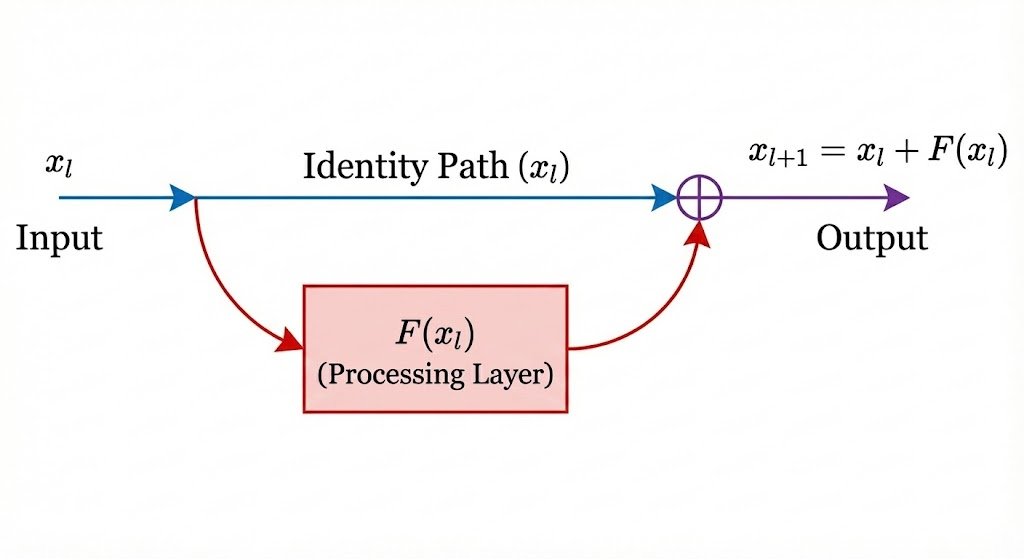

![alt text](basic_res_layer.png)

# A Basic Residual Block with FLAX NNX
Let's implement a simple residual block using FLAX NNX.

In [ ]:
!pip install -q -U jax jaxlib flax optax ray[default,train,data] tensorflow-datasets clu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 58.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.1/80.1 MB 17.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.0/488.0 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.0/220.0 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 169.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from flax import nnx # Use the new NNX API
import optax
import ray
import ray.train
import ray.data
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


In [3]:
print(f"JAX Devices: {jax.devices()}")
print(f"Ray Version: {ray.__version__}")

JAX Devices: [TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0)]
Ray Version: 2.53.0


In [ ]:
class ResBlock(nnx.Module):
    def __init__(self, channels, rngs: nnx.Rngs):
        # A simple Pre-Activation ResNet block
        self.norm1 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv1 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.norm2 = nnx.BatchNorm(channels, rngs=rngs)
        self.conv2 = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
    
    def __call__(self, x, train=True):
        # Identity path
        residual = x
        
        # F(x) path
        y = self.norm1(x, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv1(y)
        
        y = self.norm2(y, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv2(y)
        
        # Add residual
        return residual + y


The code above implements a simple residual block using FLAX NNX.

The `ResBlock` class inherits from `nnx.Module`, which is the base class for all neural network modules in FLAX NNX. Unlike older Flax versions, an NNX module is a native [PyTree](https://docs.jax.dev/en/latest/pytrees.html) (a fundamental container-like structure in JAX), meaning it can be passed directly into JAX transformations.

We then define a series of `nnx.BatchNorm` and `nnx.Conv` layers in the `__init__` method, which are standard components in convolutional neural networks, and are used to normalise the inputs, which stabilises training, and to apply convolutional filters, which extract features from the 2D input data, allowing the network to learn spatial hierarchies.

While JAX is a functional programming library, FLAX NNX allows us to use an object-oriented, stateful approach to define our models, making it more intuitive for those familiar with traditional deep learning frameworks.

In the `__call__` method, we define the forward pass using these layers. The final output, `residual + y`, adds the unmodified input (`residual`) to the transformed output (`y`), implementing the residual connection.

In [ ]:
nnx.display(ResBlock, channels=64)

## A Basic ResNet
Lets now use our `ResBlock`s to build a simple ResNet-like architecture.

In [ ]:
class ResNetModel(nnx.Module):
    def __init__(self, num_classes=100, width=64, depth=3, rngs: nnx.Rngs=None):
        self.conv_in = nnx.Conv(3, width, kernel_size=(3, 3), padding=1, rngs=rngs)
        
        # Stack blocks
        self.blocks = [
            ResBlock(width, rngs=rngs) for _ in range(depth)
        ]
        
        self.norm_final = nnx.BatchNorm(width, rngs=rngs)
        self.linear_out = nnx.Linear(width, num_classes, rngs=rngs)

    def __call__(self, x, train=True):
        x = self.conv_in(x)
        for block in self.blocks:
            x = block(x, train=train)
        
        x = self.norm_final(x, use_running_average=not train)
        x = nnx.relu(x)
        
        # Global Average Pooling
        x = jnp.mean(x, axis=(1, 2))
        x = self.linear_out(x)
        return x

In [ ]:
# Test Instantiation
rngs = nnx.Rngs(0)
model = ResNetModel(width=64, depth=4, rngs=rngs)
dummy_input = jnp.ones((1, 32, 32, 3))
output = model(dummy_input, train=False)
print(f"Model Output Shape: {output.shape}")

In [ ]:
nnx.display(model)

The code above implements a simple ResNet-like model using FLAX NNX. 

We use an `nnx.Conv` layer, a series of our `ResBlock`s, and a final `nnx.BatchNorm` and `nnx.Linear` layer to get the final logits used for class prediction`.

The `__call__` method defines the forward pass using these layers, as well as activation functions to introduce non-linearity, and a Global Average Pooling (GAP) operation to reduce the spatial dimensions of the output before the final linear layer.

![alt text](basic_resnet.png)

# Training a ResNet with Ray Train and FLAX NNX
Now that we have our ResNet model defined, let's set up a training loop using Ray Train and FLAX NNX.

### Dataset
We'll use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html), which consists of 60,000 32x32 color images in 100 classes, with 600 images per class. There are 50,000 training images and 10,000 test images.

We'll use Ray Data to load and preprocess the dataset. Ray Data provides a simple and efficient way to handle large datasets in a distributed manner.

In [ ]:
def get_cifar100_streaming(split='train', batch_size=128):
    # For simplicity we use tfds here, which Ray Data can wrap directly.
    # In practice, you would probably use something like `ray.data.read_parquet()`,
    # but the end result is the same, a ray.data.Dataset object which loads data in a streaming fashion 
    # lazily, and works with various other Ray Data and Ray Train features.
    ds = ray.data.from_tfds(
        tfds.load('cifar100', split=split, as_supervised=True)
    )
    
    def preprocess(batch):
        # Normalize to [0, 1] and then standardize
        images = batch['image']
        images = images.astype('float32') / 255.0
        # Mean/Std for CIFAR-100
        mean = np.array([0.5071, 0.4867, 0.4408], dtype='float32')
        std = np.array([0.2675, 0.2565, 0.2761], dtype='float32')
        images = (images - mean) / std
        
        batch['image'] = images
        # Labels are ready 
        return batch

    # A core feature in Ray Data is map() and map_batches(). 
    # These apply a function to elements in the dataset, either one at a time (map) or in batches (map_batches),
    # and are applied lazily.
    # They can be pipelined together since each transformation produces a new Dataset object.
    ds = ds.map_batches(preprocess, batch_format="numpy")
    
    # In a real distributed setting with Ray Train, we would shard the dataset here.
    # For a single-device notebook demo, we can just use the iterator.
    # We use batch_format="numpy" for direct JAX compatibility
    return ds.iter_batches(batch_size=batch_size, batch_format="numpy", prefetch_batches=2)


In [ ]:
# Verify data
sample_iter = get_cifar100_streaming(split='train', batch_size=4)
sample_batch = next(sample_iter)
print(f"Sample Batch Shape: {sample_batch['image'].shape}") 
# Note: Ray returns numpy arrays.
# We will convert to JAX arrays inside the loop.

## Hyper-Connections (HC)

The concept of [Hyper-Connections](https://arxiv.org/pdf/2409.19606) was introduced by ByteDance in 2024, and generalises the Residual Connection. Instead of a fixed Identity mapping ($I \cdot x$), we allow the network to *learn* how to pass information from layer $l$ to $l+1$ using a learnable linear transformation $H^{res}$.

$$ x_{l+1} = H^{res} x_l + H^{post} F(H^{pre} x_l) $$

Here, $x$ effectively contains multiple "streams" of information. $H^{res}$ allows these streams to mix linearly in the skip connection.



### The Problem: Instability
While this increases expressivity (the network can choose to ignore the skip, or amplify specific features), it introduces a major flaw: **Gain Unboundedness**.
If the eigenvalues of $H^{res}$ deviate from 1, the signal magnitude can grow or shrink exponentially with depth, just like in plain non-residual networks. This makes training deep HC networks very unstable.

Let's implement an HC Block where we split our channels into $N$ streams and learn the mixing.

## JAX NNX and Ray

### JAX NNX
JAX has traditionally relied on a purely functional programming model (stateless functions, immutable data). **NNX** is a new experimental API from Flax that brings a more familiar, Pythonic, Object-Oriented experience to JAX, similar to PyTorch, while retaining JAX's transform capabilities (`jit`, `grad`, `vmap`).

In NNX:
*   **Modules** are Python objects that hold state (`nnx.Param`, `nnx.Variable`).
*   **State management** is explicit but handled for you during transforms.



# Manifold-Constrained Hyper-Connections (mHC) with JAX NNX and Ray

This notebook explores the concepts introduced in the paper **"mHC: Manifold-Constrained Hyper-Connections"**. We will explore the evolution of skip connections in deep learning, from standard Residual connections to Hyper-Connections, and finally to the proposed Manifold-Constrained Hyper-Connections.

We will preserve the structure of the exploration:
1.  **Residual Connections:** The foundation of modern LLMs.
2.  **Hyper-Connections (HC):** A more expressive but unstable generalization.
3.  **Manifold-Constrained Hyper-Connections (mHC):** The proposed solution using the Birkhoff Polytope.

We will implement these models using **JAX NNX** (the new object-oriented neural network library for JAX) and train them using **Ray Data** and **Ray Train**.

## Prerequisites & Installation

We need to install JAX (with TPU support if on Colab), Ray, and other utilities.

In [ ]:
# Generic Training Loop using NNX
def train_model(model_cls, model_kwargs, epochs=5, learning_rate=1e-3):
    # Initialize Model & Optimizer
    rngs = nnx.Rngs(42)
    model = model_cls(**model_kwargs, rngs=rngs)
    optimizer = nnx.Optimizer(model, optax.adamw(learning_rate))
    
    # Define Loss & Step
    @nnx.jit
    def train_step(model, optimizer, batch):
        images, labels = jnp.array(batch['image']), jnp.array(batch['label'])
        
        def loss_fn(model):
            logits = model(images, train=True)
            loss = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
            acc = (jnp.argmax(logits, axis=-1) == labels).mean()
            return loss, acc

        # Compute gradients with NNX state handling
        grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
        (loss, acc), grads = grad_fn(model)
        
        optimizer.update(grads)
        return loss, acc

    # Training
    print(f"Starting training for {model_cls.__name__}...")
    
    for epoch in range(epochs):
        data_iter = get_cifar100_streaming(split='train')
        avg_loss = 0
        avg_acc = 0
        steps = 0
        
        for i, batch in enumerate(data_iter):
            # batch is dictionary from Ray
            loss, acc = train_step(model, optimizer, batch)
            avg_loss += loss
            avg_acc += acc
            steps += 1
            
            if i % 100 == 0:
                print(f"Epoch {epoch+1}, Step {i}, Loss: {loss:.4f}, Acc: {acc:.4f}")
        
        print(f"Epoch {epoch+1} Completed. Avg Loss: {avg_loss/steps:.4f}, Avg Acc: {avg_acc/steps:.4f}")
    
    return model

# Train Baseline (Short run for demo)
# In a real notebook, increase epochs.
train_model(ResNetModel, {'width': 64, 'depth': 4}, epochs=2)

In [ ]:
class HCBlock(nnx.Module):
    def __init__(self, channels, num_streams, rngs: nnx.Rngs):
        self.num_streams = num_streams
        self.channels = channels
        
        # H_res: Learnable mixing of streams in the skip connection
        # Implemented as a Dense layer acting on the reshaped stream dimension
        # Or a 1x1 Conv that mixes all channels
        self.h_res = nnx.Linear(channels, channels, use_bias=False, rngs=rngs)
        
        # H_pre and H_post can be part of the Conv block F(x) usually, 
        # but here we make them explicit for the formula.
        self.h_pre = nnx.Linear(channels, channels, use_bias=False, rngs=rngs)
        self.h_post = nnx.Linear(channels, channels, use_bias=False, rngs=rngs)
        
        # Standard F(x)
        self.norm = nnx.BatchNorm(channels, rngs=rngs)
        self.conv = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)

    def __call__(self, x, train=True):
        # x shape: (Batch, H, W, Channels)
        
        # 1. Skip Path: learnable mixing
        skip = self.h_res(x)
        
        # 2. Residual Path: H_post * F(H_pre * x)
        y = self.h_pre(x)
        y = self.norm(y, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv(y)
        y = self.h_post(y)
        
        return skip + y

class HCModel(nnx.Module):
    def __init__(self, num_classes=100, width=64, depth=3, num_streams=4, rngs: nnx.Rngs=None):
        self.conv_in = nnx.Conv(3, width, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.blocks = [HCBlock(width, num_streams, rngs=rngs) for _ in range(depth)]
        self.norm_final = nnx.BatchNorm(width, rngs=rngs)
        self.linear_out = nnx.Linear(width, num_classes, rngs=rngs)

    def __call__(self, x, train=True):
        x = self.conv_in(x)
        for block in self.blocks:
            x = block(x, train=train)
        x = self.norm_final(x, use_running_average=not train)
        x = nnx.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        return self.linear_out(x)

# Training HC Model
# Note: This might be unstable or diverge if trained for long or if depth is large.
train_model(HCModel, {'width': 64, 'depth': 4, 'num_streams': 4}, epochs=2)

## 5. Manifold-Constrained Hyper-Connections (mHC)

The **mHC** paper introduces a solution to the instability of Hyper-Connections: **Manifold Constraints**.
Instead of allowing $H^{res}$ to be any matrix, we constrain it to the **Birkhoff Polytope** $\mathcal{B}_N$, the set of doubly stochastic matrices.

A Doubly Stochastic Matrix $M$ satisfies:
1.  $M_{ij} \ge 0$ (Non-negative)
2.  $\sum_j M_{ij} = 1$ (Rows sum to 1)
3.  $\sum_i M_{ij} = 1$ (Columns sum to 1)

This constraint ensures that the gain of the residual path is bounded, preventing the signal explosion, while still allowing the network to dynamically mix and route information between streams.

### Construction using Sinkhorn-Knopp
We can learn an unconstrained parameter matrix $W$, and project it onto $\mathcal{B}_N$ using the **Sinkhorn-Knopp algorithm** (iterative row and column normalization).

$$ H^{res} = \text{Sinkhorn}(\phi(W)) $$

where $\phi$ ensures positivity (e.g., sigmoid/exp).

Let's implement the Sinkhorn projection and the mHC Block.

In [ ]:
# Sinkhorn Iteration in JAX
@jax.jit
def sinkhorn_knopp(log_alpha, n_iters=5):
    # Start with exp(log_alpha) to ensure positivity
    # Use log-space for numerical stability if needed, 
    # but for simple projection matrix operations, standard space is fine usually.
    # Here we do standard space.
    matrix = jnp.exp(log_alpha)
    
    def body_fn(i, mat):
        # Normalize Rows
        mat = mat / (jnp.sum(mat, axis=-1, keepdims=True) + 1e-6)
        # Normalize Cols
        mat = mat / (jnp.sum(mat, axis=-2, keepdims=True) + 1e-6)
        return mat

    matrix = jax.lax.fori_loop(0, n_iters, body_fn, matrix)
    return matrix

class mHCBlock(nnx.Module):
    def __init__(self, channels, num_streams, rngs: nnx.Rngs):
        self.num_streams = num_streams
        self.channels = channels
        self.dim_per_stream = channels // num_streams
        
        # Raw parameters for the mixing matrix (num_streams x num_streams)
        # We start near identity-like behavior or random
        self.h_res_logits = nnx.Param(jax.random.normal(rngs.params(), (num_streams, num_streams)))
        
        self.conv = nnx.Conv(channels, channels, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.norm = nnx.BatchNorm(channels, rngs=rngs)
    
    def __call__(self, x, train=True):
        # x shape: (B, H, W, C)
        B, H, W, C = x.shape
        
        # 1. Compute Projected H_res
        h_res = sinkhorn_knopp(self.h_res_logits) # (S, S)
        
        # 2. Reshape x to apply mixing on streams
        # (B, H, W, S, D)
        x_reshaped = x.reshape(B, H, W, self.num_streams, self.dim_per_stream)
        
        # 3. Apply H_res: "S S, ... S D -> ... S D" 
        # We want to mix the 'S' dimension.
        # einsum: i j (mixing) * ... j k (streams) -> ... i k
        skip = jnp.einsum('ij, bhwjk -> bhwik', h_res, x_reshaped)
        skip = skip.reshape(B, H, W, C)
        
        # 4. Feedforward Path (Standard)
        y = self.norm(x, use_running_average=not train)
        y = nnx.relu(y)
        y = self.conv(y)
        
        return skip + y

class mHCModel(nnx.Module):
    def __init__(self, num_classes=100, width=64, depth=3, num_streams=8, rngs: nnx.Rngs=None):
        self.conv_in = nnx.Conv(3, width, kernel_size=(3, 3), padding=1, rngs=rngs)
        self.blocks = [mHCBlock(width, num_streams, rngs=rngs) for _ in range(depth)]
        self.norm_final = nnx.BatchNorm(width, rngs=rngs)
        self.linear_out = nnx.Linear(width, num_classes, rngs=rngs)

    def __call__(self, x, train=True):
        x = self.conv_in(x)
        for block in self.blocks:
            x = block(x, train=train)
        x = self.norm_final(x, use_running_average=not train)
        x = nnx.relu(x)
        x = jnp.mean(x, axis=(1, 2))
        return self.linear_out(x)

# Train mHC Model
train_model(mHCModel, {'width': 64, 'depth': 4, 'num_streams': 8}, epochs=2)

## 6. Comparison and Conclusion

We have implemented three architectures:
1.  **Residual Network:** Uses Identity $I$ for skip connections.
2.  **Hyper-Connected Network:** Uses unconstrained $H$ for skip connections.
3.  **mHC Network:** Uses Doubly Stochastic $P_M$ for skip connections.

The **mHC** architecture provides a middle ground: it offers more expressivity than strict Identity (allowing cross-stream routing) while maintaining the stability guarantees crucial for deep model training, preventing the unbounded gain problem associated with raw Hyper-Connections.

### Next Steps / Exercises
*   Increase the depth to 50+ layers to see the instability of HC vs mHC more clearly.
*   Visualize the learned `h_res` matrices in mHC to see how information routes between streams (e.g., is it learning to permute? broadcast?).
*   Scale up to a Transformer architecture (mHC-Attention) as described in the paper.
